In [1]:
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# === Parameters ===
input_csv = "train_clean6.csv"
output_csv = "train_clean6_img.csv"
output_npy = "image_vectors.npy"
resize_shape = (64, 64)  # Resize images to 64x64 RGB
num_threads = 28         # Number of threads

# === Load dataset ===
df = pd.read_csv(input_csv)

# === Pre-allocate list for image vectors ===
image_vectors = [None] * len(df)

# === Create a session for connection pooling ===
session = requests.Session()

# === Function to download and process a single image ===
def process_image(url):
    try:
        response = session.get(url, timeout=5)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize(resize_shape, Image.BILINEAR)  # Faster resizing
        vec = np.array(img).flatten()
    except Exception:
        # On failure, return zero vector
        vec = np.zeros((resize_shape[0] * resize_shape[1] * 3,), dtype=np.uint8)
    return vec

# === Parallel processing with order preserved ===
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = {executor.submit(process_image, url): i for i, url in enumerate(df["image_link"])}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing images"):
        idx = futures[future]
        image_vectors[idx] = future.result()  # Preserve row order

# === Convert to NumPy array and save ===
image_vectors = np.array(image_vectors, dtype=np.uint8)
np.save(output_npy, image_vectors)

# === Add index column to CSV ===
df["image_vector_index"] = range(len(image_vectors))
df.to_csv(output_csv, index=False)

print(f"Image embeddings saved to {output_npy}")
print(f"Updated CSV saved to {output_csv}")

Processing images: 100%|██████████| 75000/75000 [1:26:11<00:00, 14.50it/s]  


Image embeddings saved to image_vectors.npy
Updated CSV saved to train_clean6_img.csv


In [5]:
import numpy as np

output_npy = "image_vectors.npy"

# Load the numpy file
vectors = np.load(output_npy)

print("Shape:", vectors.shape)

# Count zero vectors
zero_mask = np.all(vectors == 0, axis=1)
zero_count = np.sum(zero_mask)
nonzero_count = vectors.shape[0] - zero_count

print(f"Total vectors: {vectors.shape[0]}")
print(f"Zero vectors (failed images): {zero_count}")
print(f"Non-zero vectors: {nonzero_count}")

# Quick sanity check on a non-zero vector
if nonzero_count > 0:
    first_nonzero_idx = np.where(~zero_mask)[0][0]
    print("Example non-zero vector index:", first_nonzero_idx)
    print("First 1000 values of that vector:", vectors[first_nonzero_idx][:1000])


Shape: (75000, 12288)
Total vectors: 75000
Zero vectors (failed images): 369
Non-zero vectors: 74631
Example non-zero vector index: 0
First 1000 values of that vector: [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 

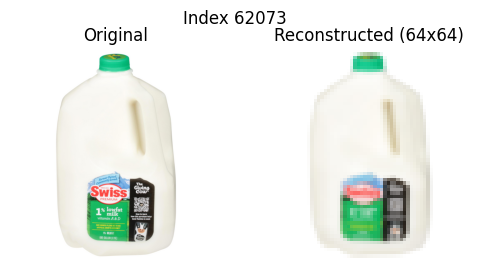

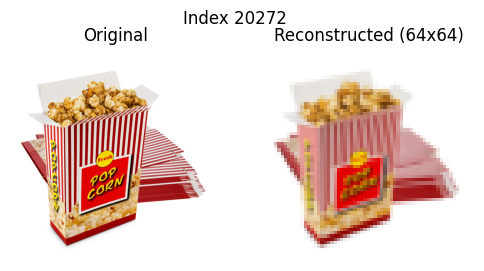

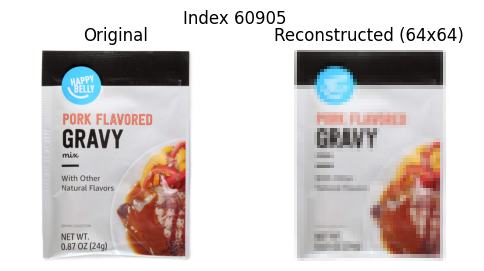

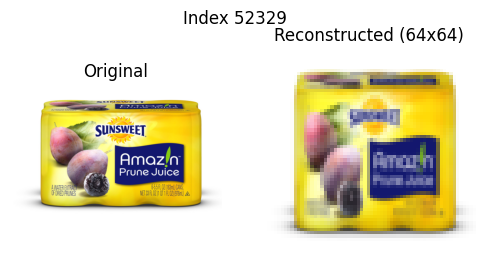

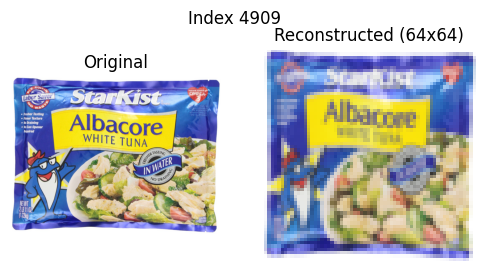

In [9]:
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import random

# === Parameters ===
csv_file = "train_clean6_img.csv"
npy_file = "image_vectors.npy"
resize_shape = (64, 64)

# Load data
df = pd.read_csv(csv_file)
image_vectors = np.load(npy_file)

# Pick random indices to test
sample_indices = random.sample(range(len(df)), 5)

for idx in sample_indices:
    url = df.loc[idx, "image_link"]
    vector = image_vectors[idx]

    # Reconstruct vector into image
    img_array = vector.reshape(resize_shape[1], resize_shape[0], 3)  # (64,64,3)
    reconstructed_img = Image.fromarray(img_array.astype("uint8"))

    # Download original image
    try:
        response = requests.get(url, timeout=5)
        orig_img = Image.open(BytesIO(response.content)).convert("RGB")
    except:
        orig_img = None

    # Show side by side
    plt.figure(figsize=(6,3))
    if orig_img:
        plt.subplot(1,2,1)
        plt.imshow(orig_img)
        plt.title("Original")
        plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(reconstructed_img)
    plt.title("Reconstructed (64x64)")
    plt.axis("off")
    plt.suptitle(f"Index {idx}")
    plt.show()
